# 학습데이터 읽어오기

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

samples = np.loadtxt('samples.data', np.float32)
answer = np.loadtxt('answer.data', np.float32)
# 1차원 벡터로 만들어줌 
answer = answer.reshape((answer.size, 1))

# opencv 내장함수인 knn알고리즘 사용해서 학습
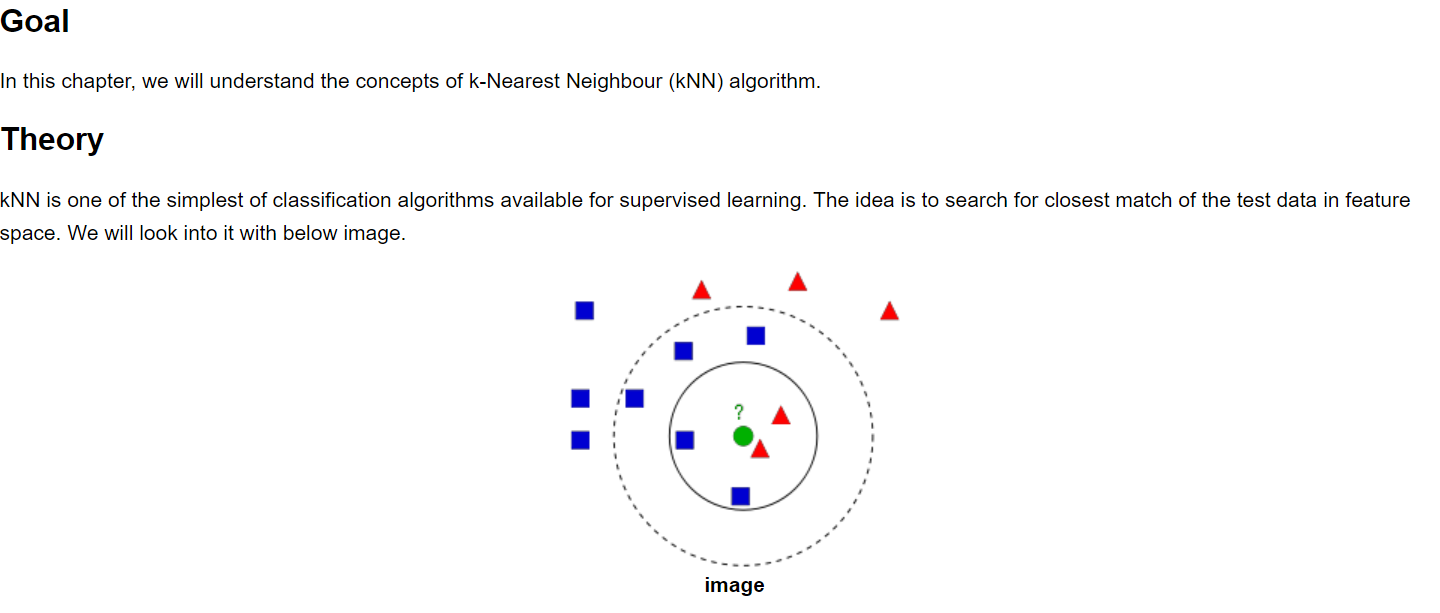

In [2]:
model = cv2.ml.KNearest_create()
model.train(samples, cv2.ml.ROW_SAMPLE, answer)

True

# test할 이미지 전처리

Text(0.5, 1.0, 'after processing')

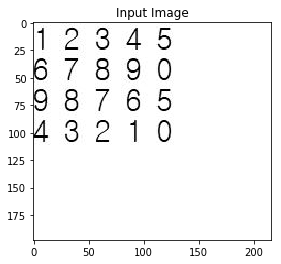

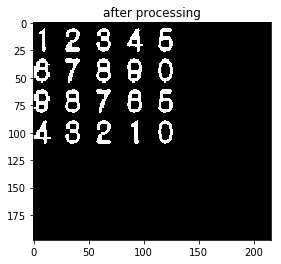

In [28]:
img = cv2.imread('./input/test1.jpg',  cv2.IMREAD_GRAYSCALE)
img = np.uint8(img)
# input img
plt.figure(1)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')

# 기본적으로 gaussian filter 적용
blur_img = cv2.GaussianBlur(img, (5,5), 0)
    
# 히스토그램의 평균값이 125 보다 작으면 감마보정을 통해 밝게 해줌
if np.mean(blur_img) < 125:
    gamma_img = np.uint8((1 * np.power(blur_img/255, 0.4)) * 255)
else:
    gamma_img = blur_img

# 분산이 적을경우 숫자 인식이 쉽지 않아 밝은것은 밝게 어두운 것은 어둡게 설정
# 히스토 그램 균일화를 할경우 전체이미지에 적용이 되어 분산이 지나치게 커지게 된다.
# 그래서 작은 영역마다 균등화 해주는 clahe(Contrast Limited Adaptive Histogram Equalization)을 적용 시켰다.
if np.var(gamma_img) < 125:
    # contrast limit가 2이고 title의 size는 8X8
    clahe = cv2.createCLAHE(clipLimit= 2.0, tileGridSize=(8,8))
    contrast_img = clahe.apply(gamma_img)
else:
    contrast_img = gamma_img

# 적절한 threshold값 찾아 이진화
thresh = cv2.adaptiveThreshold(contrast_img, 255, 1, 1, 9, 3)
# thresh = contrast_img

# 모폴로지 closing 연산
kernel = np.ones((4,4),np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.figure(5)
plt.imshow(closing, cmap = 'gray')
plt.title('after processing')


# 테스트 이미지 contour 찾기

In [29]:
test, contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# 모델 테스트하고 output 확인(숫자 검출, 개수)

In [33]:
# 출력하기 위한 어레이
out = np.zeros(img.shape, np.uint8)
numbers = []

for cnt in contours:
    if cv2.contourArea(cnt) > 30:
        [x, y, w, h] = cv2.boundingRect(cnt)
        if h > 18 and h < 100:
            # 기존이미지에 숫자라고 판단되는 영역을 사각형 만들어주고
            cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)            
            roi = thresh[y:y+h, x:x+h]
            roismall = cv2.resize(roi, (10, 10))
            roismall = roismall.reshape((1, 100))
            roismall = np.float32(roismall)
            # 가장 가까운 점(y)을찾아 그곳에 클러스터링 해주는 과정이다.
            retbal, results, neigh_resp, dists = model.findNearest(roismall, k = 1)
            # 정답을 string으로 변환해주고 numbers어레이에 추가
            string = str(int(results[0][0]))
            numbers.append(string)
            # 빈검은화면에 string으로 인식한 것 똑같은 위치에 그려주기
            cv2.putText(out, string, (x, y + h), 0, 1, (255,255,255), 2)

# 숫자 개수 출력하기
for i in range(10):
    print(i, " 개수 : " ,numbers.count(str(i) ))
print("총 개수 : ", len(numbers))
cv2.imshow('input', img)
cv2.waitKey(0)
cv2.imshow('model output', out)
cv2.waitKey(0)
cv2.destroyAllWindows()

0  개수 :  0
1  개수 :  2
2  개수 :  0
3  개수 :  3
4  개수 :  2
5  개수 :  2
6  개수 :  4
7  개수 :  2
8  개수 :  1
9  개수 :  4
총 개수 :  20
